
# TP CNN interpretation: CAM and Guided Grad-CAM
### Diane LINGRAND

diane.lingrand@univ-cotedazur.fr   
Octobre 2023

## Introduction

In [5]:
from IPython.display import Image
import tensorflow
print(tensorflow.__version__)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation
import matplotlib.pyplot as plt


2.15.0


**The GPU**



To enable GPU backend in Google colab for your notebook:

1.   Runtime (top left corner) -> Change runtime type
2.   Put GPU as "Hardware accelerator"
3.   Save.

Or run the next cell:

In [6]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


### Loading the dataset
In this part, we will use photographies of animals from the kaggle dataset [animals-10](https://www.kaggle.com/alessiocorrado99/animals10). Please connect to their site before loading the dataset from this [zip file](http://www.i3s.unice.fr/~lingrand/raw-img.zip). Decompress the zip file on your disk.

If you are using google colab, there is no need to download the dataset because I have a copy on my drive. You just need add to your drive this shared folder: https://drive.google.com/drive/folders/15cB1Ky-7OTUqfcQDZZyzc5HArt0GA6Sm?usp=sharing
You need to click on the link and click on "Add shortcut to Drive" and then select "My Drive".

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.metrics import confusion_matrix, f1_score

import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
# when processing time is long, it's nice to see the progress bar
#!pip install tqdm
from tqdm import tqdm

### loading train data

Please read the code before running any of the cells!

In [13]:
# datasetRoot='/home/lingrand/Ens/MachineLearning/animals/raw-img/'
#datasetRoot='/whereYouPutTheImages/'
datasetRoot='/content/drive/My Drive/raw-img/'
# I suggest to reduce the number of classes for a first trial.
# If you finish this notebook before the end of the course, you can add more classes (and images per class).
classes = ['mucca', 'elefante', 'gatto'] #, 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0
reducedSizePerClass = 200 #in order to reduce the number of images per class
totalImg = nbClasses * reducedSizePerClass
xTrain = np.empty(shape=(totalImg,224,224,3))
yTrain = []
first = True
i= 0
for cl in classes:
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*reducedSizePerClass #len(listImages) # note that here ...
    for pathImg in tqdm(listImages[:reducedSizePerClass]): # and here, we have reduced the data to be loaded (only 1000 per class)
        img = image.load_img(pathImg, target_size=(224,224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTrain[i,:,:,:] = im
        i += 1
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)
yTrain = tensorflow.keras.utils.to_categorical(yTrain, nbClasses)


100%|██████████| 200/200 [00:28<00:00,  7.06it/s]

600
(600, 224, 224, 3)


In order to speed-up the time spent on this part of the lab, you may have noticed that we reduced the number of classes and the number of images per class. You can change these few lines of code if you want to work on the whole dataset.

### loading test data

In [14]:
#you need to use the same classes for the test dataset than for the train dataset
rootTest = datasetRoot+'test/'
classLabel = 0

totalTestImg = 0
for cl in classes:
    totalTestImg += len(glob.glob(rootTest+cl+'/*'))

print("There are ",totalTestImg, " images in test dataset.")
xTest = np.empty(shape=(totalTestImg,224,224,3))
yTest = []
i = 0

for cl in classes:
    listImages = glob.glob(rootTest+cl+'/*')
    yTest += [classLabel]*len(listImages)
    for pathImg in listImages:
        img = image.load_img(pathImg, target_size=(224, 224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        if(np.max(im)==0):
            print('n')
        xTest[i,:,:,:] = im.copy()
        if(np.max(xTest[i])==0):
            print('m')
        i+=1
    classLabel += 1
print(len(yTest))

yTest = tensorflow.keras.utils.to_categorical(yTest, nbClasses)

There are  991  images in test dataset.
991


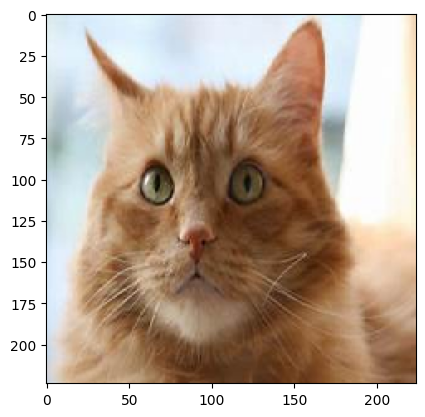

In [15]:
i=135
img = image.load_img(listImages[i], target_size=(224, 224))
plt.imshow(img)
plt.show()

## CAM Class Activation Map

In [26]:
VGGmodel = VGG16(weights='imagenet', include_top=False)
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m) # your code
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation='softmax')(m) #layer (m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)


In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [30]:
ourCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=3, mode='auto', baseline=None, restore_best_weights=False)

In [31]:
# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[ourCallback],verbose=1)

Epoch 1/2000
4/4 [==============================] - 4s 936ms/step - loss: 4.8497 - accuracy: 0.4271 - val_loss: 3.3452 - val_accuracy: 0.4917
Epoch 2/2000
4/4 [==============================] - 2s 650ms/step - loss: 2.4820 - accuracy: 0.5771 - val_loss: 1.5954 - val_accuracy: 0.7500
Epoch 3/2000
4/4 [==============================] - 2s 629ms/step - loss: 1.5149 - accuracy: 0.6833 - val_loss: 1.1539 - val_accuracy: 0.7917
Epoch 4/2000
4/4 [==============================] - 3s 685ms/step - loss: 1.0093 - accuracy: 0.7750 - val_loss: 1.0659 - val_accuracy: 0.7917
Epoch 5/2000
4/4 [==============================] - 3s 689ms/step - loss: 0.6990 - accuracy: 0.8375 - val_loss: 0.9426 - val_accuracy: 0.8167
Epoch 6/2000
4/4 [==============================] - 2s 645ms/step - loss: 0.5328 - accuracy: 0.8687 - val_loss: 0.6996 - val_accuracy: 0.8333
Epoch 7/2000
4/4 [==============================] - 3s 697ms/step - loss: 0.4132 - accuracy: 0.8938 - val_loss: 0.6027 - val_accuracy: 0.8583
Epoch 

In [33]:
# RECOVER THE WEIGHTS OF THE LAST LAYER

# layer = model.get_layer(#the name of the last dense layer)
layer = model.get_layer("dense_5")

w = layer.get_weights()   # as W has 2 elements ....weight and bias and we are considering w so we choose index 0 that is w[0]
print("number of weights: ", len(w))
w2 = w[0]
print(w2.shape)
# IS IT CORRECT ?

number of weights:  2
(512, 3)


In [39]:
# COMPUTE THE FEATURES MAPS FOR xTest
# allFeatures = ###.predict(xTest)
allFeatures = VGGmodel.predict(xTest)


31/31 [==============================] - 4s 114ms/step


In [35]:
# PREDICT THE CLASSES FOR xTest
# predClasses = ###.predict(xTest)
predClasses = model.predict(xTest)


31/31 [==============================] - 4s 124ms/step


In [40]:
allFeatures

array([[[[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   2.058888  , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,  38.336514  , ...,   2.4422643 ,
            0.        ,   0.        ],
         ...,
         [  0.        ,   0.        ,  11.652727  , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ]],

        [[  0.        ,   0.        ,   0.        , ...,   0.        ,
            0.        ,   0.        ],
         [ 11.271638  ,   0.        ,  23.721514  , ...,   0.        ,
            0.        ,   0.        ],
         [ 37.48239   ,   0.        ,  37.453144  , ...,   0.        ,
            0.        ,   0.     

In [36]:
xTest.shape

(991, 224, 224, 3)

In [48]:
index = 900 # choose one index for one test image
maps = allFeatures[index]
print("dim of maps = ", maps.shape)

dim of maps =  (7, 7, 512)


In [49]:
#predicted class
cl = np.argmax(predClasses[index])
print("class = ", cl)

class =  2


In [52]:
# we = ## extract the weights associated to the predicted class

# we = ## extract the weights associated to the predicted class

# layer = model.get_layer('dense_5')
we = layer.get_weights()[0]
w = we[:,cl]



In [54]:
w.shape

(512,)

In [55]:
# COMPUTE THE CAM map

cam = np.inner(maps,w)

In [56]:
cam

array([[ -2.219324  ,   9.841598  ,   6.5802054 ,  13.040674  ,
         -8.325235  , -13.960989  ,  -4.191744  ],
       [ 23.743925  ,  92.077225  ,  96.78545   ,  64.75298   ,
        -20.645662  , -16.274176  ,  -3.3831072 ],
       [ 14.916368  ,  81.844734  ,  90.7583    ,  43.9884    ,
        -28.18062   , -13.908441  ,   6.798928  ],
       [ -2.5930943 ,  28.845722  ,  40.57235   ,   4.8756833 ,
        -16.902863  ,  -9.764041  ,   0.1284353 ],
       [ -0.42724088,  24.53537   ,  27.69086   ,  11.560477  ,
         21.701485  ,  22.984032  ,  -1.2745979 ],
       [ -4.385406  ,  36.95358   ,  52.7647    ,  20.327715  ,
         15.742034  ,  26.879694  ,   5.9425673 ],
       [-12.464791  ,  -0.809556  ,   8.862251  ,  -3.279703  ,
         -5.2832265 ,   1.2989016 ,  -5.414768  ]], dtype=float32)

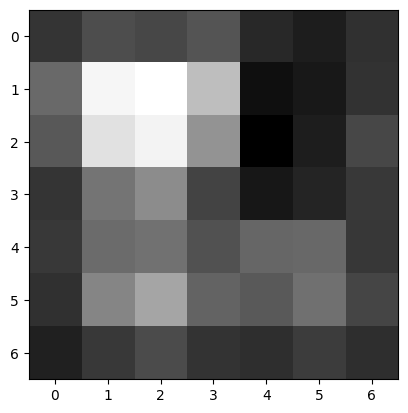

In [57]:
# rescale values of the cam map
leMin = np.min(cam)
leMax = np.max(cam)
camimg = (cam-leMin)/(leMax-leMin)
plt.imshow(cam, cmap = plt.cm.gray)


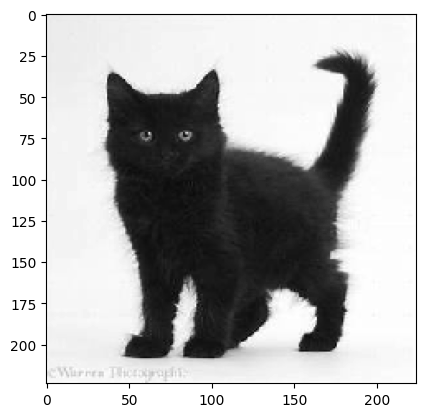

In [61]:
# display the image in grey levels
# plt.imshow(0.5*image[:,:,1],cmap=plt.cm.gray)
image =xTest[index]
plt.imshow(0.5*image[:,:,1],cmap=plt.cm.gray)

plt.show()

In [62]:
print(image[:,:,1].shape)

(224, 224)


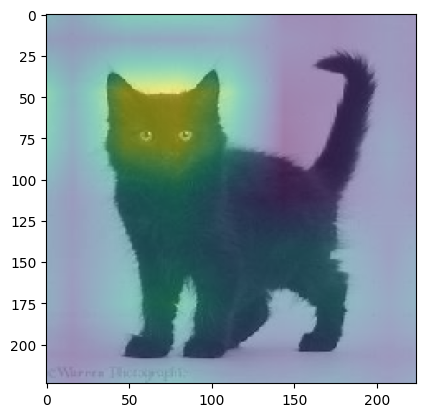

In [63]:
# and add the rescaled cam map with false colors and transparency
from skimage.transform import resize
plt.imshow(resize(camimg, (224,224)))
plt.imshow(image[:,:,1],cmap=plt.cm.gray, alpha=0.5)
plt.show()

## Grad-CAM

In [64]:
import tensorflow as tf

In [65]:
# example of gradient tape

with tf.GradientTape() as tape:
    output, predictions = model(np.array([img]))
    c = np.argmax(predictions)
    print("class = ", c)
    loss = predictions[:, cl]

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
from skimage.transform import resize
plt.imshow(resize(gradcamimg, (224,224)))
plt.colorbar()
plt.imshow(image[:,:,1],cmap=plt.cm.gray, alpha=0.4)
plt.show

### Guided GradCAM